In [16]:
from utils import *

In [17]:
input_dir = '../results/reports'
temperatures = ['LN', 'RT']
tmpsamtec_fembs = [7, 24, 27, 55, 75]
samtec_fembs = []
for femb in tmpsamtec_fembs:
    if femb < 10:
        samtec_fembs.append('FEMB0{}'.format(femb))
    else:
        samtec_fembs.append('FEMB{}'.format(femb))

In [18]:
samtec_fembs

['FEMB07', 'FEMB24', 'FEMB27', 'FEMB55', 'FEMB75']

In [19]:
def selectFEMBs(input_dir='', fembs_to_exclude=[], temperature='LN'):
    listfemb_dir = os.listdir(input_dir)
    fembs_to_keep = []
    for fembdir in listfemb_dir:
        split_femb = fembdir.split('_')
        if (split_femb[0] not in samtec_fembs) & (temperature in fembdir):
                fembs_to_keep.append(fembdir)
    return fembs_to_keep

In [20]:
selectFEMBs(input_dir=input_dir, fembs_to_exclude=samtec_fembs)

['FEMB111_LN_150pF',
 'FEMB102_LN_150pF',
 'FEMB106_LN_150pF',
 'FEMB103_LN_150pF',
 'FEMB112_LN_150pF',
 'FEMB110_LN_150pF',
 'FEMB113_LN_150pF',
 'FEMB105_LN_150pF',
 'FEMB101_LN_150pF',
 'FEMB114_LN_150pF',
 'FEMB107_LN_150pF',
 'FEMB108_LN_150pF',
 'FEMB104_LN_150pF',
 'FEMB115_LN_150pF',
 'FEMB109_LN_150pF']

In [21]:
os.listdir(input_dir)[:5]

['FEMB55_RT_150pF',
 'FEMB104_RT_150pF',
 'FEMB111_LN_150pF',
 'FEMB112_RT_150pF',
 'FEMB102_LN_150pF']

## at LN

In [22]:
T = 'LN'
fembs = selectFEMBs(input_dir=input_dir, fembs_to_exclude=samtec_fembs, temperature=T)
femb_LN_cali_dirs = ['/'.join([input_dir, Dir, 'CALI']) for Dir in fembs]

In [23]:
femb_LN_cali_dirs

['../results/reports/FEMB111_LN_150pF/CALI',
 '../results/reports/FEMB102_LN_150pF/CALI',
 '../results/reports/FEMB106_LN_150pF/CALI',
 '../results/reports/FEMB103_LN_150pF/CALI',
 '../results/reports/FEMB112_LN_150pF/CALI',
 '../results/reports/FEMB110_LN_150pF/CALI',
 '../results/reports/FEMB113_LN_150pF/CALI',
 '../results/reports/FEMB105_LN_150pF/CALI',
 '../results/reports/FEMB101_LN_150pF/CALI',
 '../results/reports/FEMB114_LN_150pF/CALI',
 '../results/reports/FEMB107_LN_150pF/CALI',
 '../results/reports/FEMB108_LN_150pF/CALI',
 '../results/reports/FEMB104_LN_150pF/CALI',
 '../results/reports/FEMB115_LN_150pF/CALI',
 '../results/reports/FEMB109_LN_150pF/CALI']

In [24]:
gain_Larasic = ['14_0mVfC', '4_7mVfC', '25_0mVfC', '7_8mVfC']
BL_gain = ['_'.join(['200mVBL', gain]) for gain in gain_Larasic]
def get_encbin_forconfig(femb_LN_cali_dirs='', BL_gain=[]):
    enc_bins = []
    for config in BL_gain:
        one_config = []
        for Dir in femb_LN_cali_dirs:
            list_bins = os.listdir(Dir)
            for b in list_bins:
                if ('_'.join(['ENC', config]) in b) & ('.bin' in b) & ('sgp1' not in b):
                    one_config.append('/'.join([Dir, b]))
        enc_bins.append(one_config)
    return enc_bins

def get_enc_means(femb_LN_cali_dirs='', BL_gain=[]):
    enc_bins = get_encbin_forconfig(femb_LN_cali_dirs=femb_LN_cali_dirs, BL_gain=BL_gain)
    data_df = pd.DataFrame()
    for ienc in range(len(enc_bins)):
        config = '_'.join(((enc_bins[ienc][0].split('/')[-1]).split('.')[0]).split('_')[1:])
        mean_enc_all_fembs = []
        std_enc_all_fembs = [] ##
        femb_list = []
        for femb in enc_bins[ienc]:
            tmp_fembname = (femb.split('/')[3]).split('_')[0]
            femb_list.append(tmp_fembname)
            with open(femb, 'rb') as fp:
                renc = pickle.load(fp)
            mean_enc_all_fembs.append(np.mean(renc))
            std_enc_all_fembs.append(np.std(renc))
            
        oneconfig_df = pd.DataFrame({'femb_id': femb_list, 'mean_enc_{}'.format(config): mean_enc_all_fembs,
                                    'std_enc_{}'.format(config): std_enc_all_fembs})
        if ienc==0:
            data_df = pd.concat([data_df, oneconfig_df], axis=1)
        else:
            data_df = data_df.merge(oneconfig_df, how='left', on='femb_id')
    return data_df

def get_plot(femb_LN_cali_dirs='', BL_gain=[], temperature='LN', output_dir=''):
    data_df = get_enc_means(femb_LN_cali_dirs=femb_LN_cali_dirs, BL_gain=BL_gain)
    cols = data_df.columns[1:]
    colors = ['red', 'green', 'blue', 'orange']
    print(len(cols))
    plt.figure(figsize=(15, 6))
#     for i, col in enumerate(cols):
    i = 0
    for ii in range(0, len(cols), 2):
        coly = cols[ii]
        colerr = cols[ii+1]
        config = '_'.join(coly.split('_')[3:])
        data_df = data_df.sort_values(by='femb_id', ascending=True)
        plt.errorbar(x=data_df['femb_id'], y=data_df[coly], yerr=data_df[colerr], color=colors[i],
                     capsize=5, label=config)
        i += 1
    
    plt.xlabel('FEMB', fontsize=15)
    plt.ylabel('mean ENC', fontsize=15)
    plt.xticks(fontsize=10); plt.yticks(fontsize=12)
    plt.legend(fontsize=10)
    plt.title('_'.join(['mean ENC_{}'.format(temperature), '{}'.format(BL_gain[0].split('_')[0]), 'REPORT']), fontsize=12)
    plt.savefig('/'.join(['../results', 'mean_ENC_{}_report.jpg'.format(temperature)]))

8


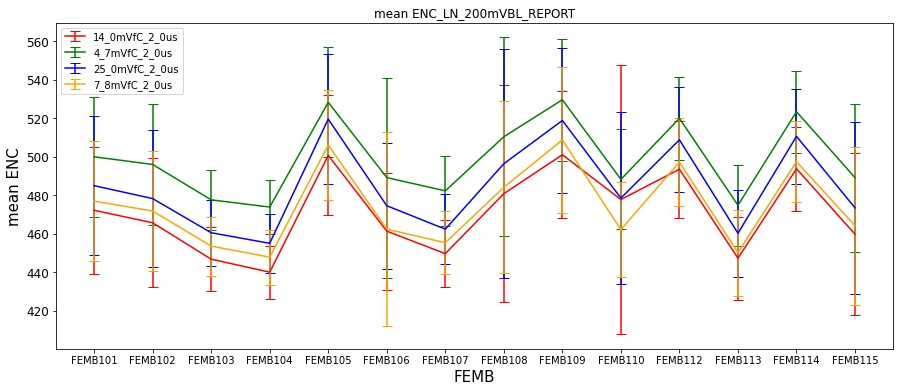

In [25]:
get_plot(femb_LN_cali_dirs=femb_LN_cali_dirs, BL_gain=BL_gain, temperature=T)

## at RT

In [26]:
T = 'RT'
fembs = selectFEMBs(input_dir=input_dir, fembs_to_exclude=samtec_fembs, temperature=T)
femb_LN_cali_dirs = ['/'.join([input_dir, Dir, 'CALI']) for Dir in fembs]

In [27]:
femb_LN_cali_dirs

['../results/reports/FEMB104_RT_150pF/CALI',
 '../results/reports/FEMB112_RT_150pF/CALI',
 '../results/reports/FEMB106_RT_150pF/CALI',
 '../results/reports/FEMB103_RT_150pF/CALI',
 '../results/reports/FEMB111_RT_150pF/CALI',
 '../results/reports/FEMB105_RT_150pF/CALI',
 '../results/reports/FEMB115_RT_150pF/CALI',
 '../results/reports/FEMB107_RT_150pF/CALI',
 '../results/reports/FEMB102_RT_150pF/CALI',
 '../results/reports/FEMB108_RT_150pF/CALI',
 '../results/reports/FEMB110_RT_150pF/CALI',
 '../results/reports/FEMB101_RT_150pF/CALI',
 '../results/reports/FEMB113_RT_150pF/CALI',
 '../results/reports/FEMB114_RT_150pF/CALI',
 '../results/reports/FEMB109_RT_150pF/CALI']

8


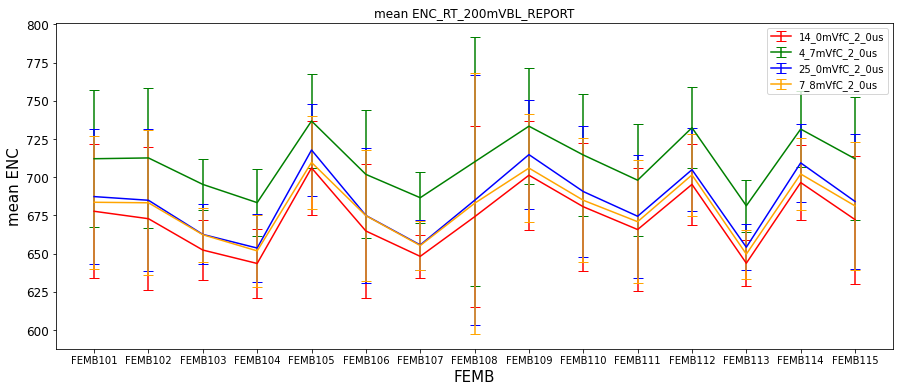

In [28]:
get_plot(femb_LN_cali_dirs=femb_LN_cali_dirs, BL_gain=BL_gain, temperature=T)